In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### **Load data**

Besides the ASHRAE Global Thermal Comfort Database II, we also introduce datasets that have detailed information of countries' climate features in order to get more insightful findings:

- First the climate data, which contains **wind_speed**, **precipitation** and **fog_presence** of global countries from 2020 Jan to Mar:

- Second, the **annual average temperature** of global cities.

- Lastly, the **country codes** for mapping geographical locations.

In [2]:
# Load data
df = pd.read_csv("../input/ashrae-global-thermal-comfort-database-ii/ashrae_db2.01.csv", low_memory=False)
df_climate = pd.read_csv("../input/covcsd-covid19-countries-statistical-dataset/temperature_data.csv", low_memory=False) # wind, precipitation, fog data from Jan to Mar 
df_temperature = pd.read_csv("../input/world-average-temperature/Avg_World_Temp_2020.csv",low_memory=False) # Annual average temperature
df_country = pd.read_csv("../input/014-world-gdp-with-codes/2014_world_gdp_with_codes.csv") # Geographical location

In [3]:
df.head()

,Publication (Citation),Data contributor,Year,Season,Koppen climate classification,Climate,City,Country,Building type,Cooling startegy_building level,...,Subject«s height (cm),Subject«s weight (kg),Blind (curtain),Fan,Window,Door,Heater,Outdoor monthly air temperature (C),Outdoor monthly air temperature (F),Database
0,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,162.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
1,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,154.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
2,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,173.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
3,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,167.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
4,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,178.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107583 entries, 0 to 107582
Data columns (total 70 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   Publication (Citation)                            105928 non-null  object 
 1   Data contributor                                  107583 non-null  object 
 2   Year                                              107335 non-null  float64
 3   Season                                            107342 non-null  object 
 4   Koppen climate classification                     107583 non-null  object 
 5   Climate                                           107583 non-null  object 
 6   City                                              107570 non-null  object 
 7   Country                                           107583 non-null  object 
 8   Building type                                     103384 non-null  object 
 9   Cool

In [5]:
print("Number of values by season:\n",df['Season'].value_counts())
print("Season missing values: ",df['Season'].isna().sum())
print()
print("Number of values by building type: \n", df['Building type'].value_counts())
print("Building type missing values: ",df['Building type'].isna().sum())
print()
print("Number of values by age: \n", df['Age'].value_counts())
print("Age missing values: ",df['Age'].isna().sum())

Number of values by season:
 Summer    42202
Winter    37533
Autumn    14734
Spring    12873
Name: Season, dtype: int64
Season missing values:  241

Number of values by building type: 
 Office                 67755
Classroom              17852
Multifamily housing    10401
Others                  6555
Senior center            821
Name: Building type, dtype: int64
Building type missing values:  4199

Number of values by age: 
 25.00    4315
45.00    3459
35.00    3210
18.00    2170
55.00    2040
         ... 
94.00       1
19.50       1
13.67       1
18.50       1
33.50       1
Name: Age, Length: 95, dtype: int64
Age missing values:  64004


In [6]:
# Dealing with missing age data
df['Age'].fillna((df['Age'].mean()), inplace=True)

In [7]:
# Create filter conditions based on our senario setting
season_con = df.Season == 'Summer' # Summer Olympic game
building_type_con = df['Building type'].isin(['Office', 'Multifamily housing']) # Those building types are similar to apartments
age_con = (df.Age >= 15) & (df.Age <= 40) # General age range of athletes

# Filter rows by conditions
df_con = df.loc[season_con & building_type_con & age_con]

In [8]:
# Include columns that we are interested in, drop duplication or unnecessary data
to_include = ['Climate','City','Country', # Geographical information
              'Age','Sex','Clo','Met', # Personal features
              'Thermal sensation', # Thermal comfort
              'Air temperature (C)','Relative humidity (%)','Air velocity (m/s)' # Environmental features
             ]

df_con = df_con[to_include]
df_con.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30896 entries, 74 to 104038
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Climate                30896 non-null  object 
 1   City                   30883 non-null  object 
 2   Country                30896 non-null  object 
 3   Age                    30896 non-null  float64
 4   Sex                    14633 non-null  object 
 5   Clo                    26742 non-null  float64
 6   Met                    26155 non-null  float64
 7   Thermal sensation      28115 non-null  float64
 8   Air temperature (C)    30217 non-null  float64
 9   Relative humidity (%)  26292 non-null  float64
 10  Air velocity (m/s)     26671 non-null  float64
dtypes: float64(7), object(4)
memory usage: 2.8+ MB


In [9]:
# Dealing with missing data
# Drop rows have missing thermal sensation, air temperature, humidity, and air velocity value
df_con = df_con.dropna(subset=['Thermal sensation', 'Air temperature (C)', 'Relative humidity (%)', 'Air velocity (m/s)'])

# Use .round() function to get integer thermal comfort values
df_con['Thermal sensation'] = df_con['Thermal sensation'].round()

Text(0.5, 1.0, 'What features influence thermal sensation')

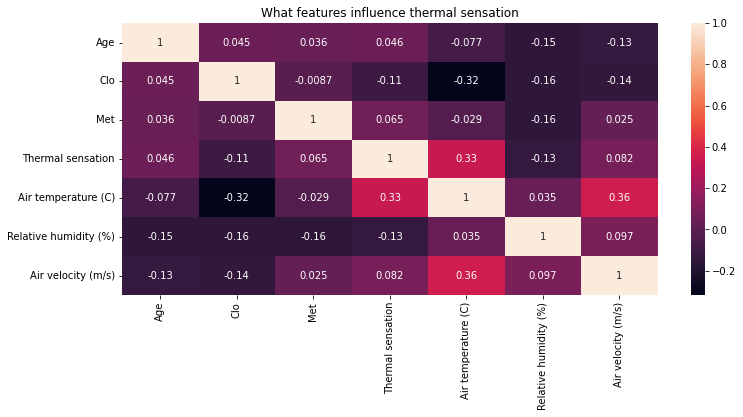

In [10]:
# Explore what features influence thermal sensation
plt.figure(figsize=(12, 5))
sns.heatmap(df_con.corr(), annot=True)

plt.title('What features influence thermal sensation')

In [11]:
df_climate.head()

,Date,State,Country,Cumulative_cases,Cumulative_death,Daily_cases,Daily_death,Latitude,Longitude,Temperature,Wind_speed,Precipitation,Fog_Presence
0,22-01-2020,NaN,Afghanistan,0,0,0,0,33.0,65.0,5.89,9.4,0.00,0
1,23-01-2020,NaN,Afghanistan,0,0,0,0,33.0,65.0,5.56,14.9,0.00,1
2,24-01-2020,NaN,Afghanistan,0,0,0,0,33.0,65.0,4.50,10.4,0.17,1
3,25-01-2020,NaN,Afghanistan,0,0,0,0,33.0,65.0,7.78,6.1,0.57,1
4,26-01-2020,NaN,Afghanistan,0,0,0,0,33.0,65.0,6.00,10.8,0.00,1


In [12]:
# Wind_speed, Precipitation, Fog_Presence
# Select relevant columns
to_include_climate = ['Country','Wind_speed','Precipitation','Fog_Presence']
df_climate = df_climate[to_include_climate]

# In the climate dataset, UK is written as United Kingdom, USA as US
# Replace the country names before merging data
df_climate['Country'] = df_climate['Country'].replace(["US","United Kingdom"],["USA","UK"])

# Summarize daily climate data into average value
df_climate['Wind_speed'] = df_climate.groupby('Country')['Wind_speed'].transform('mean').round(1)
df_climate['Precipitation'] = df_climate.groupby('Country')['Precipitation'].transform('mean').round(1)
df_climate['Fog_Presence'] = df_climate.groupby('Country')['Fog_Presence'].transform('mean').round(1)

# Remove duplicates
df_climate.drop_duplicates(inplace=True)

# Merge climate data with ASHRAE dataset
df_con = pd.merge(df_con, df_climate, how='left')

In [13]:
df_temperature.head()

,Unnamed: 0,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Avg_Year,Continent
0,0,Algeria,Algiers,11.2,11.9,12.8,14.7,17.7,21.3,24.6,25.2,23.2,19.4,15.2,12.1,17.4,Africa
1,1,Algeria,Tamanrasset,12.8,15.0,18.1,22.2,26.1,28.9,28.7,28.2,26.5,22.4,17.3,13.9,21.7,Africa
2,2,Algeria,Reggane,16.0,18.2,23.1,27.9,32.2,36.4,39.8,38.4,35.5,29.2,22.0,17.8,28.3,Africa
3,3,Angola,Luanda,26.7,28.5,28.6,28.2,27.0,23.9,22.1,22.1,23.5,25.2,26.7,26.9,25.8,Africa
4,4,Benin,Cotonou,27.3,28.5,28.9,28.6,27.8,26.5,25.8,25.6,26.0,26.7,27.6,27.3,27.2,Africa


In [14]:
# Annual temperature
df_temperature = df_temperature[['Country','Avg_Year']]
df_temperature['Avg_Year'] = df_temperature.groupby('Country')['Avg_Year'].transform('mean').round(1)
df_temperature.drop_duplicates(inplace=True)
df_temperature['Country'] = df_temperature['Country'].replace(["United States","United Kingdom"],["USA","UK"])
df_temperature.rename(columns={"Avg_Year": "Temperature"}, inplace=True)

df_con = pd.merge(df_con, df_temperature, how='left')

# Calculate average temperature by Koppen climate zone
df_con['Temperature by climate'] = df_con.groupby('Climate')['Temperature'].transform('mean').round(1)
df_con.head()

,Climate,City,Country,Age,Sex,Clo,Met,Thermal sensation,Air temperature (C),Relative humidity (%),Air velocity (m/s),Wind_speed,Precipitation,Fog_Presence,Temperature,Temperature by climate
0,Humid subtropical,Texas,USA,28.0,NaN,0.57,1.0,-1.0,24.3,36.8,0.27,6.2,0.1,0.4,15.3,18.2
1,Humid subtropical,Texas,USA,30.0,NaN,0.57,1.1,-1.0,25.7,33.1,0.09,6.2,0.1,0.4,15.3,18.2
2,Humid subtropical,Texas,USA,29.0,NaN,0.57,1.1,1.0,24.6,34.9,0.06,6.2,0.1,0.4,15.3,18.2
3,Humid subtropical,Texas,USA,26.0,NaN,0.57,1.0,0.0,26.4,31.7,0.13,6.2,0.1,0.4,15.3,18.2
4,Humid subtropical,Texas,USA,37.0,NaN,0.57,1.0,2.0,25.0,33.3,0.07,6.2,0.1,0.4,15.3,18.2


In [15]:
# Define our thermal comfort color palette
# Red - Hot, Green - Comfortable, Blue - Cold
colors = ['#004bf2', '#6281ef', '#87b9e1', '#9af785', '#ffc8b9', '#ff8e8c', '#d65036']
sns.set_palette(sns.color_palette(colors))

Text(0.5, 0.98, 'Relationships between temperature, humidity, and thermal sensation (by country)')

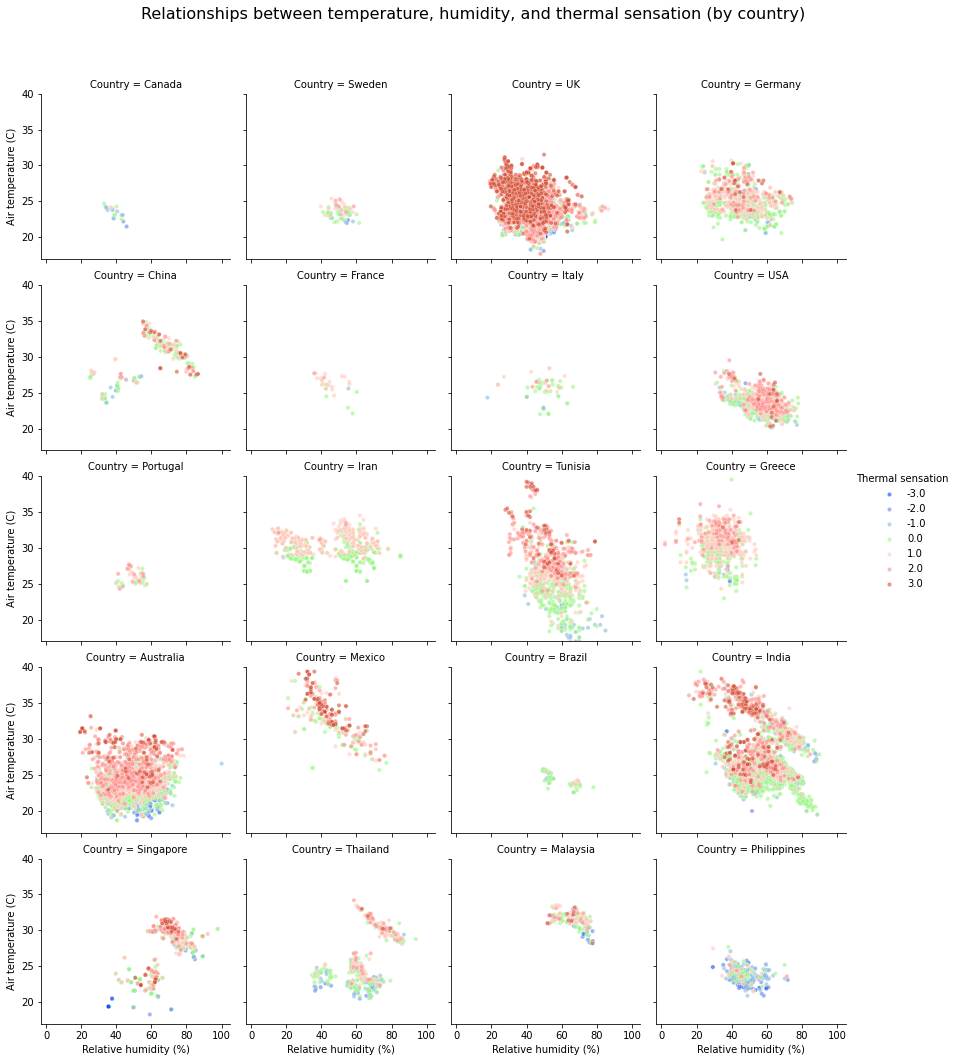

In [16]:
# By countries
# Sort country order according to their average remperature
df_con = df_con.sort_values(by = ['Temperature'], ascending=True)

g = sns.FacetGrid(
    data=df_con, 
    col='Country', 
    hue='Thermal sensation', 
    col_wrap=4, 
    ylim=(17,40)
)

g.map_dataframe(
    sns.scatterplot, 
    'Relative humidity (%)', 
    'Air temperature (C)', 
    size=0.5, 
    alpha=0.6
)

g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationships between temperature, humidity, and thermal sensation (by country)',fontsize=16)

Text(0.5, 0.98, 'Relationships between temperature, humidity, and thermal sensation (by climate zone)')

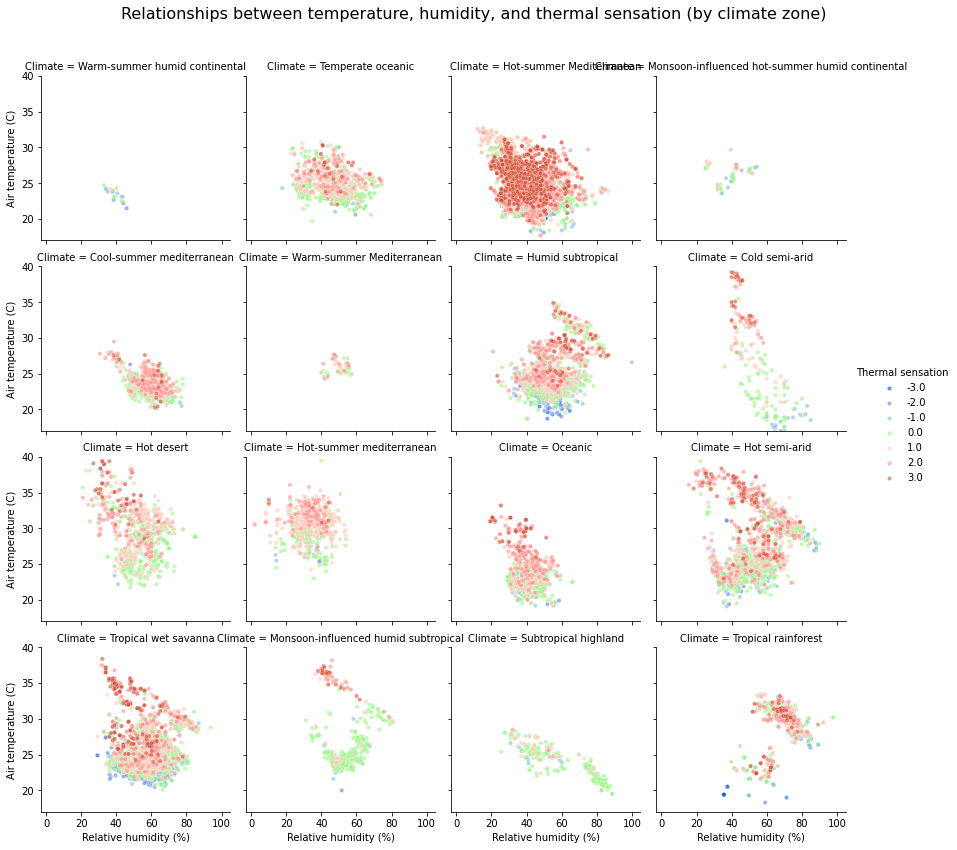

In [17]:
# By climate zones
# Sort climate zone order according to their average remperature
df_con = df_con.sort_values(
    by = ['Temperature by climate'], 
    ascending=True
)

g = sns.FacetGrid(
    data=df_con[['Relative humidity (%)','Air temperature (C)','Thermal sensation','Climate']].dropna(), 
    col='Climate', 
    hue='Thermal sensation', 
    col_wrap=4, 
    ylim=(17,40)
)

g.map_dataframe(
    sns.scatterplot, 
    'Relative humidity (%)', 
    'Air temperature (C)', 
    size=0.5, 
    alpha=0.6
)

g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationships between temperature, humidity, and thermal sensation (by climate zone)',fontsize=16)

In [18]:
# Find the temperatures that make most people feel comfortable by each country
df_con['Comfort temperature (C)'] = (df_con['Air temperature (C)'] - df_con['Thermal sensation']/0.35).round(1)
df_con['Comfort temperature by country (C)'] = df_con.groupby('Country')['Comfort temperature (C)'].transform('mean').round(1)

# Calculate air temperature of each country as comparison
df_con['Air temperature by country (C)'] = df_con.groupby('Country')['Air temperature (C)'].transform('mean').round(1)

Text(0.5, 1.0, 'Comfort temperature v.s. actual air temperature (by country)')

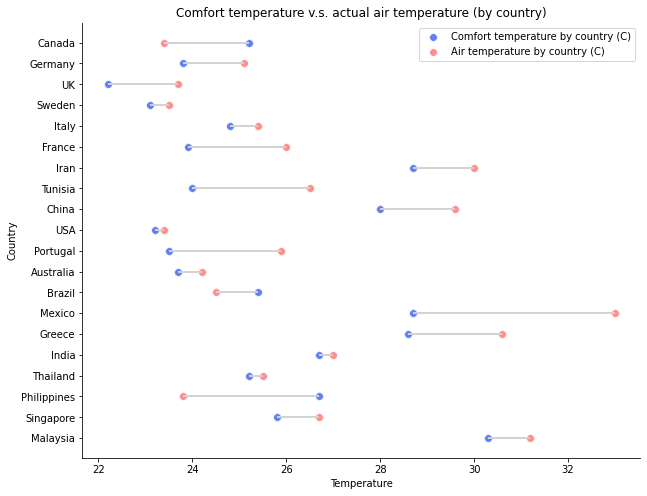

In [19]:
# Compare the comfort temperature with current air temperature
plt.figure(figsize=(10, 8))

plt.hlines(
    data=df_con, 
    y='Country', 
    xmin='Comfort temperature by country (C)', 
    xmax='Air temperature by country (C)', 
    color='lightgrey', 
    alpha=0.4
)

sns.scatterplot(
    data=df_con,
    y='Country',
    x='Comfort temperature by country (C)', 
    color='#6281ef',
    s = 60,
    label="Comfort temperature by country (C)"
)

sns.scatterplot(
    data=df_con,
    y='Country',
    x='Air temperature by country (C)', 
    color='#ff8e8c',
    s = 60,
    label="Air temperature by country (C)"
)

sns.despine()
plt.legend()
plt.ylabel("Country")
plt.xlabel("Temperature")
plt.title('Comfort temperature v.s. actual air temperature (by country)')

- <span style='color:blue'> **Blue** </span> indicates the ideal temperature to people. 
- <span style='color:red'> **Red** </span> indicates the actual air temperature when the survey was made.

In [20]:
df_con['Standard humidity by country (%)'] = df_con.loc[
    (df_con['Air temperature (C)'] >= df_con['Comfort temperature by country (C)'] - 1.5) &
    (df_con['Air temperature (C)'] <= df_con['Comfort temperature by country (C)'] + 1.5) & # 1.5 degrees around comfort temperature
    (df_con['Thermal sensation'] >= -1) &
    (df_con['Thermal sensation'] <= 1) # Within comfort thermal sensation range
].groupby('Country')['Relative humidity (%)'].transform('mean').round(1)

df_con['Standard humidity by country (%)'].fillna(df_con.groupby('Country')['Standard humidity by country (%)'].transform('mean'),inplace=True)

# Calculate relative humidity of each country as comparison
df_con['Relative humidity by country (%)'] = df_con.groupby('Country')['Relative humidity (%)'].transform('mean').round(1)

Text(0.5, 1.0, 'Standard humidity v.s. actual humidity (by country)')

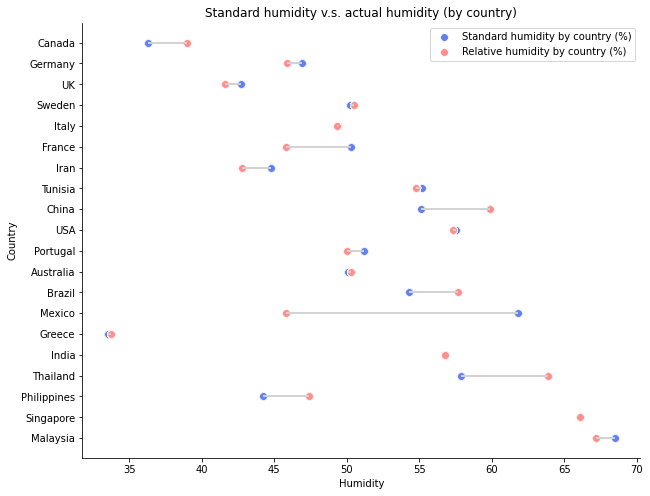

In [21]:
# Compare the standard humidity with current humidity
plt.figure(figsize=(10, 8))

plt.hlines(
    data=df_con, 
    y='Country', 
    xmin='Standard humidity by country (%)', 
    xmax='Relative humidity by country (%)', 
    color='lightgrey', 
    alpha=0.4
)

sns.scatterplot(
    data=df_con,
    y='Country',
    x='Standard humidity by country (%)', 
    color='#6281ef',
    s = 60,
    label="Standard humidity by country (%)"
)

sns.scatterplot(
    data=df_con,
    y='Country',
    x='Relative humidity by country (%)', 
    color='#ff8e8c',
    s = 60,
    label="Relative humidity by country (%)"
)

sns.despine()
plt.legend()
plt.ylabel("Country")
plt.xlabel("Humidity")
plt.title('Standard humidity v.s. actual humidity (by country)')

In [22]:
# Add on geographical location
df_country = df_country[['COUNTRY','CODE']]
df_country['COUNTRY'] = df_country['COUNTRY'].replace(["United States","United Kingdom"],["USA","UK"])
df_country.rename(columns={"COUNTRY": "Country"}, inplace=True)

df_geo = pd.merge(df_con, df_country, how='left')
df_geo = df_geo[
    ['Country',
    'Comfort temperature by country (C)',
    'Standard humidity by country (%)',
    'CODE']
].drop_duplicates(subset = ['Country'])

In [23]:
fig = go.Figure(data=go.Choropleth(
    locations = df_geo['CODE'],
    z = df_geo['Comfort temperature by country (C)'],
    text = df_geo['Country'],
    colorscale = 'agsunset',
    marker_line_color = 'white',
    marker_line_width = 0.5,
    colorbar_title = 'Comfort temperature by country (C)',
))

fig.update_layout(
    title_text='Comfort temperature by country (C)',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

In [24]:
fig = go.Figure(data=go.Choropleth(
    locations = df_geo['CODE'],
    z = df_geo['Standard humidity by country (%)'],
    text = df_geo['Country'],
    colorscale = 'YlGnBu',
    marker_line_color='white',
    marker_line_width=0.5,
    colorbar_title = 'Standard humidity by country (%)',
))

fig.update_layout(
    title_text='Standard humidity by country (%)',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)


fig.show()

Text(0.5, 1.0, 'What climate features influence thermal preference')

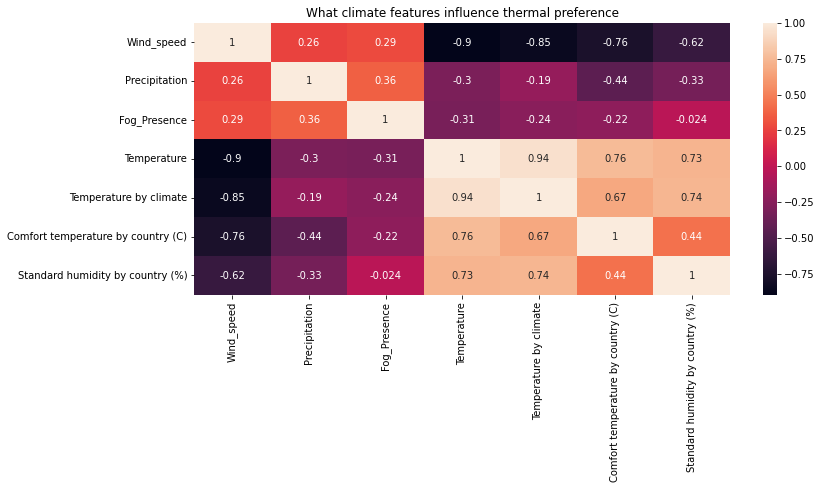

In [25]:
# Explore what factors influence comfort temperature and humidity
plt.figure(figsize=(12, 5))
sns.heatmap(df_con[['Wind_speed','Precipitation','Fog_Presence',
                   'Temperature','Temperature by climate',
                   'Comfort temperature by country (C)','Standard humidity by country (%)']].corr(), annot=True)


plt.title('What climate features influence thermal preference')

# ** Predict thermal preferences of people **

### **Temperature prediction model**
In this model, we use the "individual" as the input unit instead of "country" for ensuring enough sample size.
Therefore besides the climated features, we add in personal information [Age], and personal [Thermal sensation] value. 

In [26]:
X_to_include = [
    'Age',
    'Wind_speed',
    'Precipitation',
    'Fog_Presence',
    'Temperature',
    'Thermal sensation'
]

X = df_con[X_to_include]
y = df_con['Comfort temperature (C)']

In [27]:
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scaling
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train random forest model
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [28]:
# Model performance
MAE = mean_absolute_error(y_test, y_pred)
print("Mean absolute error: ",MAE)
print("The predicted temperatures are {} degrees Celsius around actual comfortable temperatures".format(MAE.round(1)))

Mean absolute error:  1.4720690573152868
The predicted temperatures are 1.5 degrees Celsius around actual comfortable temperatures


### **Humidity prediction model**


In [29]:
y2 = df_con['Relative humidity (%)']

# Split training and testing data
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, random_state=0)

# Scaling
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train random forest model
rf2 = RandomForestRegressor(random_state=0)
rf2.fit(X_train, y2_train)

y2_pred = rf2.predict(X_test)

# Model performance
MAE2 = mean_absolute_error(y2_test, y2_pred)
print("Mean absolute error: ",MAE2)
print("The predicted humidities are {}% around actual comfortable humidities".format(MAE2.round(1)))

Mean absolute error:  7.319821871526329
The predicted humidities are 7.3% around actual comfortable humidities


In [30]:
# Add in information of new countries
countries_to_add = ['Argentina', 'Croatia', 'Cuba', 'Jamaica', 'Japan', 'Netherlands', 'Russia','Spain', 'Switzerland', 'Thailand','Vietnam']
df_add = pd.merge(df_climate, df_temperature, how='inner')
df_add = df_add.loc[df_add['Country'].isin(countries_to_add)]

# Create a column of athelets average age
df_add['Age'] = [27.7, 27.5, 25.1, 26.4, 25.2, 27.2, 26.1, 27.1, 26.7, 24.0, 23.3]

# Set thermal sensation as comfortable
df_add['Thermal sensation'] = 0

In [31]:
df_add

,Country,Wind_speed,Precipitation,Fog_Presence,Temperature,Age,Thermal sensation
5,Argentina,10.4,0.0,0.3,15.2,27.7,0
31,Croatia,4.7,0.1,0.4,10.7,27.5,0
32,Cuba,6.7,0.0,0.0,25.2,25.1,0
65,Jamaica,9.8,0.0,0.2,27.4,26.4,0
66,Japan,7.0,0.1,0.5,15.8,25.2,0
92,Netherlands,11.0,0.1,0.5,10.2,27.2,0
109,Russia,6.7,0.1,0.8,2.3,26.1,0
118,Spain,5.7,0.1,0.3,17.9,27.1,0
123,Switzerland,13.1,0.0,0.6,9.3,26.7,0
126,Thailand,2.9,0.0,0.1,27.2,24.0,0


Let's run our pre-trained model on this new dataset.

In [32]:
X_add = df_add[X_to_include]

# Scaling
X_add = preprocessing.StandardScaler().fit(X_add).transform(X_add)

# Predicting
y_add_tem = rf.predict(X_add) # Temperature
y_add_hum = rf2.predict(X_add) # Humidity

In [33]:
# Add predicted outcomes back into the new country dataset
df_add['Comfort temperature by country (C)'] = y_add_tem.round(1)
df_add['Standard humidity by country (%)'] = y_add_hum.round(1)
df_add

,Country,Wind_speed,Precipitation,Fog_Presence,Temperature,Age,Thermal sensation,Comfort temperature by country (C),Standard humidity by country (%)
5,Argentina,10.4,0.0,0.3,15.2,27.7,0,25.3,42.8
31,Croatia,4.7,0.1,0.4,10.7,27.5,0,27.7,33.5
32,Cuba,6.7,0.0,0.0,25.2,25.1,0,25.6,55.1
65,Jamaica,9.8,0.0,0.2,27.4,26.4,0,30.9,45.2
66,Japan,7.0,0.1,0.5,15.8,25.2,0,24.0,43.6
92,Netherlands,11.0,0.1,0.5,10.2,27.2,0,23.6,42.4
109,Russia,6.7,0.1,0.8,2.3,26.1,0,23.8,37.1
118,Spain,5.7,0.1,0.3,17.9,27.1,0,26.2,51.3
123,Switzerland,13.1,0.0,0.6,9.3,26.7,0,24.2,42.5
126,Thailand,2.9,0.0,0.1,27.2,24.0,0,25.5,59.5


## **Final output**

Finally, let's explore the thermal preference patterns of both the known countries and the predicted countries. 

In [34]:
df_con['Category'] = "Known"
df_add['Category'] = "Predicted"

df_all = pd.concat(
    [
    df_con[['Country', 'Comfort temperature by country (C)', 'Standard humidity by country (%)', 'Category']].drop_duplicates(subset = ['Country']),
    df_add[['Country', 'Comfort temperature by country (C)', 'Standard humidity by country (%)', 'Category']]
    ]
)

df_all

,Country,Comfort temperature by country (C),Standard humidity by country (%),Category
18426,Canada,25.2,36.3,Known
17527,Germany,23.8,46.9,Known
23640,UK,22.2,42.7,Known
13514,Sweden,23.1,50.2,Known
13657,Italy,24.8,49.4,Known
13479,France,23.9,50.3,Known
1229,Iran,28.7,44.8,Known
4238,Tunisia,24.0,55.2,Known
2452,China,28.0,55.1,Known
22679,USA,23.2,57.5,Known


In [35]:
# Plot the thermal peference
fig = px.scatter(
    df_all, 
    x = 'Comfort temperature by country (C)', 
    y = 'Standard humidity by country (%)',
    text = 'Country',
    color = 'Category'
)

fig.update_traces(textposition='top center')
fig.update_layout(title_text='Thermal preferences in global countries', title_x=0.5, yaxis=dict(gridcolor = '#DFEAF4'), xaxis=dict(gridcolor = '#DFEAF4'), plot_bgcolor='white')
fig.show()

# **Conclusion**
In this project we explored the relationship between geographic location and people's thermal preferences. We found that personal factors such as clothing level and metabolic rate do not have a strong correlation with thermal sensation, however, environmental factors such as temperature and humidity have a noticable impact on it. 

We further added the annual average temperature, humidity, and wind speed of countries to the existing dataset. Followed by calculating the collective thermal preferences of people in the same country. Geographical maps suggest that people's temperature and humidity preferences are closely related to the latitude of the respective countries.

We try to extend the investigation of thermal preferences to more geographic areas, through building a random forest prediction model by country climate characteristics, individual thermal sensations, therefore to predict the ideal temperature and humidity of target group people in other countries.

Our prediction models yielded optimistic results, with both temperature and humidity predictions within a small margin of mean absolute error. The trained models are employed on a new dataset to obtain a more comprehensive list of ideal indoor environments for global countries.